In [1]:
###data processing assoicated package
import pickle
import glob
import numpy as np
import cv2
from pyspectral.rayleigh import Rayleigh
#import netCDF4 as nc

###drawing package
import os
os.environ['PROJ_LIB'] = 'C:\\Users\\jerry\\anaconda3\\Library\\share\\'
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

### 0.5km resolution cover area:
latitude: **-60~60**  
longitude: **85 ~ 205**   
array size: **24000*24000**

In [2]:
#print('ext shape')
y = np.arange(-59.9975,60.0025,0.005)
x = np.arange(85.0025,205.0025,0.005)

### Customized data cover area
latitude: **10~40**   
longitude: **115~140**   
array size: **6000*5000**

In [3]:
local_lat = y[14000:20000]
local_lon = x[6000:11000]
print('lat',local_lat[0],local_lat[-1])
print('lon',local_lon[0],local_lon[-1])

lat 10.002500000035809 39.99750000005116
lon 115.00249999997271 139.99749999994998


### Demo Taiwan area
latitude: **18~30**   
longitude: **118~128**  
array size: **2000*2000**

In [4]:
local_lat = y[15600:18000]
local_lon = x[6600:8600]
print('lat',local_lat[0],local_lat[-1])
print('lon',local_lon[0],local_lon[-1])

lat 18.002500000039902 29.997500000046045
lon 118.00249999996998 127.9974999999609


In [5]:
date = '202004070000'

### Load data
band 01~04   
geo information   


In [6]:
fileband=glob.glob('truecolor_data/'+date+'_band01.pkl')
with open(fileband[0], 'rb') as f:
    band01= pickle.load(f)
fileband=glob.glob('truecolor_data/'+date+'_band02.pkl')
with open(fileband[0], 'rb') as f:
    band02= pickle.load(f)
fileband=glob.glob('truecolor_data/'+date+'_band03.pkl')
with open(fileband[0], 'rb') as f:
    band03= pickle.load(f)
fileband=glob.glob('truecolor_data/'+date+'_band04.pkl')
with open(fileband[0], 'rb') as f:
    band04= pickle.load(f)
with open('truecolor_data/'+date+'_geo.pkl', 'rb') as f:
    hi_geo=pickle.load(f)
sun_az_map = hi_geo[0,:,:]
sun_zh_map = hi_geo[1,:,:]
sat_az_map = hi_geo[2,:,:]
sat_zh_map = hi_geo[3,:,:]

In [7]:
print(band02.shape)
print(band03.shape)

(3000, 2500)
(6000, 5000)


In [8]:
### resolution 1km
local_band01 = band01[800:2000,300:1300]
local_band02 = band02[800:2000,300:1300]
local_band04 =  band04[800:2000,300:1300]
### resolution 0.5km
local_band03 = band03[1600:4000,600:2600]
# geo info
local_sun_az_map = sun_az_map[1600:4000,600:2600]
local_sun_zh_map = sun_zh_map[1600:4000,600:2600]
local_sat_az_map = sat_az_map[1600:4000,600:2600]
local_sat_zh_map = sat_zh_map[1600:4000,600:2600]

In [9]:
print('Max albedo')
print(np.max(local_band01))
print(np.max(local_band02))
print(np.max(local_band03))
print(np.max(local_band04))
print('Min albedo')
print(np.min(local_band01))
print(np.min(local_band02))
print(np.min(local_band03))
print(np.min(local_band04))

Max albedo
85.35294
83.64706
93.47059
93.29412
Min albedo
6.294118
4.352941
1.588235
0.176471


### Resolution sharpening

In [10]:
print(local_band01.shape)
print(local_band03.shape)

(1200, 1000)
(2400, 2000)


In [11]:
## resolution sharping (band01, 02, 04)
band011 = cv2.resize(local_band01, (2000, 2400), interpolation=cv2.INTER_LINEAR)
band022 = cv2.resize(local_band02, (2000, 2400), interpolation=cv2.INTER_LINEAR)
band033 = local_band03
band044 = cv2.resize(local_band04, (2000, 2400), interpolation=cv2.INTER_LINEAR)

### Solar Zenith Angle Modification 

In [12]:
local_rad = np.radians(local_sun_zh_map)
local_adjust = np.cos(local_rad)
# for Rayleigh correction
local_az_diff = local_sun_az_map-local_sat_az_map

In [13]:
band011 = band011/local_adjust
band022 = band022/local_adjust
band033 = band033/local_adjust
band044 = band044/local_adjust

In [14]:
print('Max albedo')
print(np.max(band011))
print(np.max(band022))
print(np.max(band033))
print(np.max(band044))
print('Min albedo')
print(np.min(band011))
print(np.min(band022))
print(np.min(band033))
print(np.min(band044))

Max albedo
145.62526129598248
144.1392118054803
172.77734733603882
159.14572928032752
Min albedo
12.131713034585513
7.895451657685456
2.597277557673558
0.41933360294694066


In [15]:
band011[band011>100]=100
band022[band022>100]=100
band033[band033>100]=100
band044[band044>100]=100

### Rayleigh scattering correction

In [16]:
hima = Rayleigh('Himawari-8', 'ahi')

In [17]:
refl_cor_band1 = hima.get_reflectance(local_sun_zh_map, local_sat_zh_map, local_az_diff, 'ch1',band033)
refl_cor_band2 = hima.get_reflectance(local_sun_zh_map, local_sat_zh_map, local_az_diff, 'ch2',band033)
refl_cor_band3 = hima.get_reflectance(local_sun_zh_map, local_sat_zh_map, local_az_diff, 'ch3',band033)

In [18]:
cor_band011 = band011-refl_cor_band1
cor_band022 = band022-refl_cor_band2
cor_band033 = band033-refl_cor_band3

In [19]:
print('Max albedo')
print(np.max(cor_band011))
print(np.max(cor_band022))
print(np.max(cor_band033))
print('Min albedo')
print(np.min(cor_band011))
print(np.min(cor_band022))
print(np.min(cor_band033))

Max albedo
100.0
100.0
100.0
Min albedo
-2.5707880897473263
-2.0802731225943987
-1.7673198134769166


### Color  correction: hybrid green

In [20]:
cor_bandgreen=0.93*cor_band022+0.07*band044

In [21]:
cor_bandgreen[cor_bandgreen<0]=0
cor_band011[cor_band011<0]=0
cor_band033[cor_band033<0]=0

In [22]:
print(np.max(cor_band011))
print(np.max(cor_bandgreen))
print(np.max(cor_band033))
print(np.min(cor_band011))
print(np.min(cor_bandgreen))
print(np.min(cor_band033))

100.0
100.0
100.0
0.0
0.0
0.0


### Image enhancement
gamma 2.0 (^1/2)

In [23]:
enh_band01 = (cor_band011/100)**(1/2)
enh_band02 = (cor_bandgreen/100)**(1/2)
enh_band03 = (cor_band033/100)**(1/2)

### True color map drawing

In [24]:
data = np.array([enh_band01,enh_band02,enh_band03])
rgb_array=np.zeros((2400,2000,3))
rgb_array[:,:,0]=data[2,:,:]
rgb_array[:,:,1]=data[1,:,:]
rgb_array[:,:,2]=data[0,:,:]
mesh=rgb_array[:,:-1,:]
color_t=mesh.reshape((mesh.shape[0] * mesh.shape[1]),3)

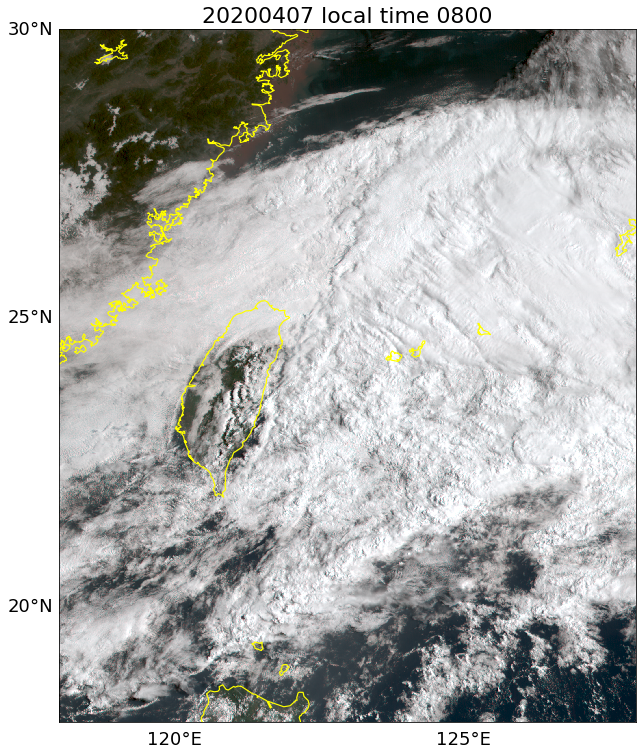

In [25]:
fig = plt.figure(figsize=(9,11)) 
m = Basemap(llcrnrlon=118, urcrnrlon=128, llcrnrlat=18, urcrnrlat=30,resolution='i')
m.drawcoastlines(linewidth=1.2,color='yellow',zorder=2)
m.drawparallels(np.arange(20., 41., 5.), labels=[1, 0, 0, 0], linewidth=0, color='k', fontsize=18)
m.drawmeridians(np.arange(120., 139., 5.), labels=[0, 0, 0, 1], linewidth=0, color='k', fontsize=18)
m.pcolormesh(local_lon,local_lat,rgb_array[:,:,2],color=color_t,zorder=1)
plt.tight_layout()
plt.title('20200407 local time 0800',fontsize=22)
plt.savefig('20200407_lt08_test.png',dpi=600)